## Fine-tune popular ConvNets for other image classification tasks


CNN models are good at learning features from images for various tasks.
We can exploit the popular architectures in two ways,
1. as feature extractor: extract features of images by feeding images into the popular models and take the intermediate layers as the output
2. as a starting model for our own tasks: fine-tune the models parameters over our own datsets. 


**Dog VS Cat**

Download and unzip the [train.zip](https://www.kaggle.com/c/dogs-vs-cats/data). Put the images into `data/dog-cat/train` folder. Then randomly put some images from the training dataset into validation dataset by (the PWD is `data/dog-cat`)

```
mkdir dog
mkdir cat
mv train/dog.* dog/
mv train/cat.* cat/
mv dog train/
mv cat train/
mkdir valid
mkdir valid/cat 
mkdir valid/dog
shuf -n 5000 -e ../train/dog/* | xargs -i mv {} dog/
shuf -n 5000 -e ../train/cat/* | xargs -i mv {} cat/
```

You can also use the following code to replce the above commands if you are not using Linux.

In [3]:
from utils import reorganize_dog_cat
# run this just once
reorganize_dog_cat("data/dog-cat")

seperate done
split done


Using TensorFlow backend.


Found 20022 images belonging to 2 classes.


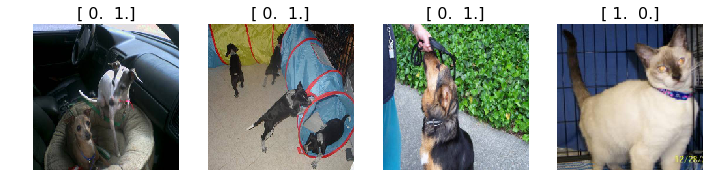

In [4]:
from utils import plots
from keras.preprocessing import image
import numpy as np

channel_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))

def preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (channels x width)
        Returns:
            Image array (transposed_channels x height x width)
    """
    x = x - channel_mean
    return x[:, ::-1] # reverse axis rgb->bgr

def get_batches(dirname,  shuffle=True, batch_size=32, class_mode='categorical', vis=False):
    """
        Takes the path to a directory, and generates batches of augmented/normalized data. 
        Yields batches indefinitely, in an infinite loop.
        See Keras documentation: https://keras.io/preprocessing/image/
    """    
    path = 'data/dog-cat/'
    if vis:        
        return image.ImageDataGenerator().flow_from_directory(
            path + dirname, target_size=(224,224), class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)
    else:
        return image.ImageDataGenerator(preprocessing_function=preprocess).flow_from_directory(
            path + dirname, target_size=(224,224), class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

batches = get_batches('train', batch_size=4, vis=True)
imgs, labels = next(batches)
# This shows the 'ground truth'
plots(imgs, titles=labels)

In [5]:
batch_size = 128
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', shuffle=False, batch_size=batch_size)

classes = {}
for c in batches.class_indices:
    classes[batches.class_indices[c]] = c 
print(classes)

Found 20022 images belonging to 2 classes.
Found 4978 images belonging to 2 classes.
{0: 'cat', 1: 'dog'}


In [8]:
from keras.models import Model
from keras.layers import Input, Dense

a = Input(shape=(32,))
b = Dense(32)(a)
model = Model(inputs=a, outputs=b)

In [6]:
from keras.applications.resnet50 import ResNet50, decode_predictions
#from keras.applications.vgg16 import VGG16


model = ResNet50()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

Use ResNet directly for prediction

In [7]:
x, y = next(batches)
preds = model.predict(x, x.shape[0])
decode_predictions(preds, 1)[0]
preds = [yi[0][1] for yi in decode_predictions(preds, 1)[0:10]]
truth = ['dog' if yi==1 else 'cat' for yi in np.argmax(y[0:10], axis=1)]
print("          Predictions           VS    Ground truth")
for (p, t) in zip(preds, truth):
    print('%30s' %p, '%10s' % t)

          Predictions           VS    Ground truth
(u'                  Egyptian_cat', '       cat')
(u'                  Walker_hound', '       dog')
(u'                        beagle', '       dog')
(u'                    bath_towel', '       cat')
(u'                     Chihuahua', '       dog')
(u'                       polecat', '       cat')
(u'                  Egyptian_cat', '       cat')
(u'                         tabby', '       cat')
(u'                         tabby', '       cat')
(u'         flat-coated_retriever', '       dog')


Fine-tune the ResNet for our own task
1. modify the network structure to generate predictions for two classes
2. fix some layers (how many?)

In [9]:
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import Model

resnet = ResNet50()
# fix all layers
for layer in resnet.layers[0:10]: layer.trainable=False 
x = resnet.outputs[-1]
x = Dense(2, activation='softmax')(x)
model = Model(input=resnet.inputs, outputs=x)

/home/wangwei/miniconda3/envs/cs5242/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


In [10]:
model.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.fit_generator(batches, 
                    steps_per_epoch=batches.samples // batch_size, 
                    epochs=1, 
                    validation_data=val_batches, 
                    validation_steps=val_batches.samples // batch_size)

Epoch 1/10
625/625 [==============================] - 169s 271ms/step - loss: 0.6588 - acc: 0.6368 - val_loss: 0.6688 - val_acc: 0.6226
Epoch 2/10
625/625 [==============================] - 167s 267ms/step - loss: 0.6291 - acc: 0.6660 - val_loss: 0.6271 - val_acc: 0.6632
Epoch 3/10
625/625 [==============================] - 167s 267ms/step - loss: 0.5532 - acc: 0.7335 - val_loss: 0.7699 - val_acc: 0.6274
Epoch 4/10
625/625 [==============================] - 167s 267ms/step - loss: 0.4481 - acc: 0.8033 - val_loss: 0.5448 - val_acc: 0.7260
Epoch 5/10
625/625 [==============================] - 167s 267ms/step - loss: 0.3719 - acc: 0.8490 - val_loss: 0.6442 - val_acc: 0.6890
Epoch 6/10
625/625 [==============================] - 167s 267ms/step - loss: 0.2957 - acc: 0.8834 - val_loss: 0.3789 - val_acc: 0.8498
Epoch 7/10
625/625 [==============================] - 167s 267ms/step - loss: 0.2363 - acc: 0.9103 - val_loss: 0.2453 - val_acc: 0.9076
Epoch 8/10
625/625 [============================

In [11]:
preds = model.predict(imgs)
idxs = np.argmax(preds, axis=1)    
for i in range(len(idxs)):
    idx = idxs[i]
    print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

  0.9847/dog
  0.9847/dog
  0.9594/dog
  0.9209/cat


In [12]:
val_batches = get_batches('valid', shuffle=False, batch_size=batch_size)
preds = model.predict_generator(val_batches, steps=100)
preds.shape

Found 4978 images belonging to 2 classes.


(3200, 2)